# Molecular Similarity of FDA Drug Subset Database

#### Data obtained from ZINC15
* "Resources." DISI, . 9 Feb 2017, 18:30 UTC. 3 Sep 2023, 08:39 <http://wiki.docking.org/index.php?title=Resources&oldid=9919>.

* The simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings.
<br>
* Algorithms have been developed to generate the same SMILES string for a given molecule; of the many possible strings, these algorithms choose only one of them. This SMILES is unique for each structure, although dependent on the canonicalization algorithm used to generate it.
<br>
* ASCII - is a character encoding standard for electronic communication. ASCII codes represent text in computers, telecommunications equipment, and other devices.
<br>
* ASCII encodes 128 specified characters into seven-bit integers. Ninety-five of the encoded characters are printable.
<br>

> * https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system
> * https://en.wikipedia.org/wiki/ASCII

In [58]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit import DataStructs
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import pandas as pd
import numpy as np
from io import StringIO
from rdkit.Chem import PandasTools
import ipywidgets as widgets
import concurrent.futures
import requests
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import json

#### Data Cleaning and Pre-Processing

In [59]:
print(rdkit.__version__)

2023.03.1


In [60]:
import platform
print(platform.python_version())

3.8.17


In [61]:
# Load the JSON data from file into a Pandas DataFrame
df = pd.read_json('D:/DataSets/fda.json')

print(df.head())

            zinc_id                                             smiles
0  ZINC000001530427                          C[C@@H]1O[C@@H]1P(=O)(O)O
1  ZINC000003807804             Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
2  ZINC000000120286                   Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1
3  ZINC000242548690  C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...
4  ZINC000000008492                                    Oc1cccc2cccnc12


##### Obtaining IUPAC Names From ZINCID's

In [62]:
import pubchempy as pcp

# Load the data with ZincID's as a column
data = df

# Define a function to get the molecule names from the ZincID
def get_molecule_name_from_zincid(zinc_id):
    try:
        compound = pcp.Compound.from_cid(int(zinc_id[4:]))
        return compound.iupac_name
    except:
        return 'Not Found'

# Apply the function to each ZincID in the data
data['Molecule Name'] = data['zinc_id'].apply(get_molecule_name_from_zincid)

# Save the data with the molecule names
data.to_csv('D:/DataSets/FDA_molecule_names.csv', index=False)

In [63]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles')
data.head(1)

,zinc_id,smiles,Molecule Name,ROMol
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,1-[1-[(4-methoxyphenyl)methyl]piperidin-4-yl]-...,<rdkit.Chem.rdchem.Mol object at 0x000001922DF...


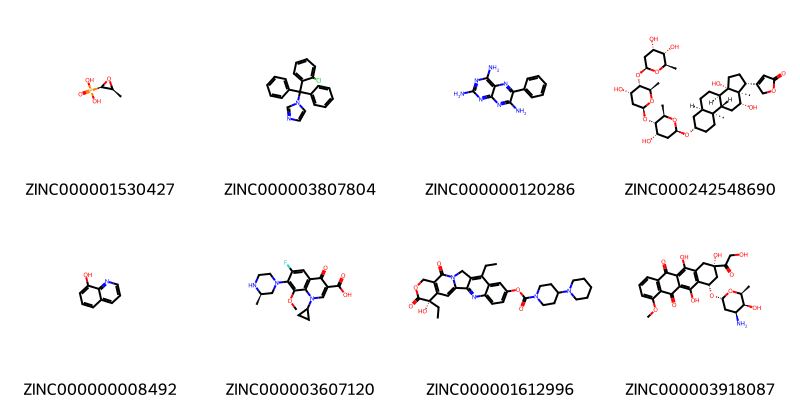

In [64]:
PandasTools.FrameToGridImage(data.head(8), legendsCol="zinc_id", molsPerRow=4)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   zinc_id        1615 non-null   object
 1   smiles         1615 non-null   object
 2   Molecule Name  1614 non-null   object
 3   ROMol          1615 non-null   object
dtypes: object(4)
memory usage: 50.6+ KB


In [66]:
data.isnull().sum()

zinc_id          0
smiles           0
Molecule Name    1
ROMol            0
dtype: int64

In [67]:
data.shape

(1615, 4)

#### Validity Check - Ensure that all SMILES strings are valid according to the SMILES notation rules.

In [68]:
# Define a list of SMILES strings from your dataset
smiles_list = data['smiles'].tolist()

# Define an empty list to store valid molecules
valid_molecules = []

# Loop over each SMILES string in the list and convert it to an RDKit molecule object
for smiles_string in smiles_list:
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles_string)
    
    # Convert the RDKit molecule object back to a SMILES string, and check for validity
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    if len(smiles) > 0:
        valid_molecules.append(mol)
    else:
        print("Invalid SMILES string:", smiles_string)

print("Number of valid molecules:", len(valid_molecules))

Number of valid molecules: 1615


#### Canonicalization - The process of converting SMILES strings into a standardized form. It ensures that chemically equivalent molecules have the same SMILES representation.

In [69]:
# Loop over each SMILES string and generate a canonical SMILES string

smiles_data = data['smiles']

canonical_smiles_list = []
for smiles in smiles_data:
    molecule = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(molecule, isomericSmiles=False, canonical=True)
    canonical_smiles_list.append(canonical_smiles)
    
print('Number of Canonicalized molecules', len(canonical_smiles_list))

Number of Canonicalized molecules 1615


#### Sanitization - Removing non-chemical characters or artifacts from SMILES strings.

In [70]:
smiles_list = data['smiles']

# Define an empty list to store sanitized molecules
sanitized_molecules = []

# Loop over each SMILES string and sanitize the molecule using RDKit
for smiles_string in smiles_list:
    # Convert the SMILES string to a RDKit molecule object
    mol = Chem.MolFromSmiles(smiles_string)

    if mol is not None:
        # Sanitize the molecule in place
        Chem.SanitizeMol(mol)
        
        # Convert the sanitized molecule to SMILES format and add it to the list of sanitized molecules
        sanitized_smiles = Chem.MolToSmiles(mol)
        sanitized_molecules.append(sanitized_smiles)

    else:
        print('Invalid SMILES: ', smiles_string)

print('Number of Sanitized molecules', len(sanitized_molecules))

Number of Sanitized molecules 1615


#### Fingerprints
##### Morgan/Circular Fingerprints
<br>

* Numbering invariant atom information into an initial atom identifier
* Identifiers are generated independently of previous identifiers and the intermediate results are discarded
* The iteration process is continued until every atom identifier is unique
>* https://oi.readthedocs.io/en/latest/bioinfo/mol_fp/ecfp.html 

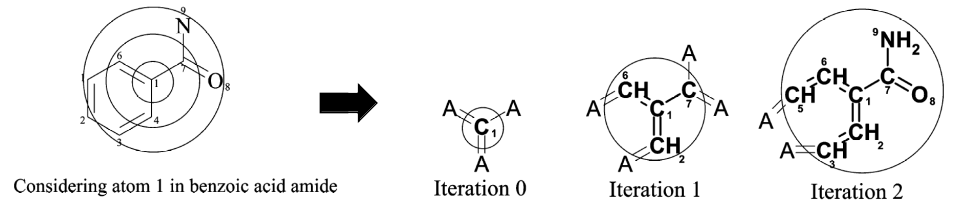

* The molecule below is represented by a series of binary bits showing the presence or absence of particular substructures.

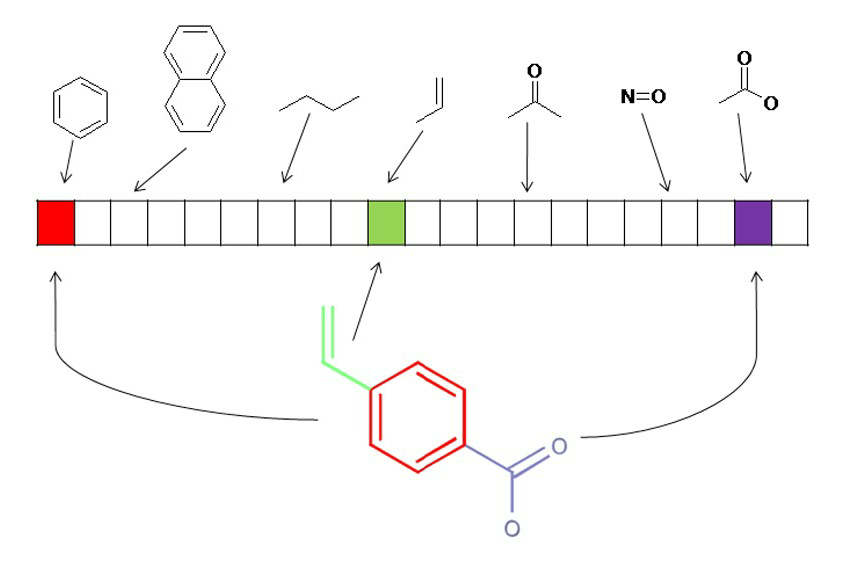
* Reference: https://www.researchgate.net/profile/Dong-Sheng-Cao?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ

* 1615 bit fingerprints was selected in order to encompass the entire similarity matrix and for ease of DataFrame and array handling. The common bit sizes used are 2048 or 1024. I find it scientifically sound to use 1615 bit size being that it's a value between the common sizes.

In [71]:
data.to_csv('D:/DataSets/FDA_Clean.csv')

In [72]:
# Convert SMILES strings to RDKit molecules
molecules = []

for smi in data['smiles']:
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            molecules.append(mol)
        else:
            print(f"Invalid SMILES string: {smi}")
    except:
        print(f"Error processing SMILES string: {smi}")
        
# Calculate Morgan3 fingerprints for the molecules
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1615) for mol in molecules]

In [73]:
# Create a DataFrame with fingerprints
df_fingerprints = pd.DataFrame({'Fingerprint': fingerprints})

# Merge the two DataFrames on their index
data = pd.concat([data, df_fingerprints], axis=1)

data.head(1)

,zinc_id,smiles,Molecule Name,ROMol,Fingerprint
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,1-[1-[(4-methoxyphenyl)methyl]piperidin-4-yl]-...,<rdkit.Chem.rdchem.Mol object at 0x000001922DF...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Tanimoto Similarity
<br>
* Also known as the Tanimoto coefficient or Jaccard index.
<br>

* The formula calculates the ratio of the number of common elements between two sets to the total number of elements in both sets. The resulting value ranges between 0 and 1, with 1 indicating that the two sets are identical and 0 indicating that they have no common elements.
<br>

>* Tanimoto similarity = C / (A + B - C)

>* Where A and B are the total number of bits in the two fingerprints being compared, and C is the number of bits that match between the two fingerprints.

In [74]:
# Calculate the similarity matrix using Tanimoto similarity
similarity_scores_arr = np.empty((len(fingerprints), len(fingerprints)), dtype=np.float32)
for i in range(len(fingerprints)):
    for j in range(i, len(fingerprints)):
        similarity_scores_arr[i,j] = DataStructs.FingerprintSimilarity(fingerprints[i], fingerprints[j])
        similarity_scores_arr[j,i] = similarity_scores_arr[i,j]

#### Data storage for modeling

In [75]:
# Save the similarity matrix to a file
np.save('similarity_matrix_1615.npy', similarity_scores_arr)

In [76]:
# Convert RDKit fingerprints to binary numpy array
def convert_fingerprints(fingerprints):
    try:
        # Convert RDKit fingerprints to binary numpy array
        n_molecules = len(fingerprints)
        n_bits = len(fingerprints[0])

        # Initialize a NumPy array to store the binary fingerprints
        fp_binary = np.zeros((n_molecules, n_bits), dtype=np.float32)

        # Convert RDKit BitVec fingerprints to binary arrays
        for i, rdkit_fp in enumerate(fingerprints):
            for j in range(n_bits):
                fp_binary[i, j] = rdkit_fp[j]

        return fp_binary
    except IndexError:
        print("Error: index out of range.")

In [77]:
# Save converted binary fingerprints to file
fp_binary = convert_fingerprints(fingerprints)
np.save('fingerprints_binary_1615.npy', fp_binary)

In [78]:
# Load fingerprint data
X = np.load('fingerprints_binary_1615.npy')

# Load similarity score data
y = np.load('similarity_matrix_1615.npy')

# Calculate statistics for similarity scores
similarity_mean = np.mean(y, axis=1)

# Create a dataframe with X and calculated similarity statistics
column_names = [f'feature_{i}' for i in range(X.shape[1])]
df_1 = pd.DataFrame(X, columns=column_names)
df_1['similarity_mean'] = similarity_mean

# Print the shape of the dataframe
print(f"DataFrame shape: {df_1.shape}")

DataFrame shape: (1615, 1616)


In [79]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Columns: 1616 entries, feature_0 to similarity_mean
dtypes: float32(1616)
memory usage: 10.0 MB


In [80]:
# Merged to match with ZINCIDs
df_1 = df_1.reset_index().rename(columns={'index':'number'})
data['zinc_id'] = data['zinc_id'].astype(str)
merged_df = df_1.merge(data, left_on='number', right_index=True)
merged_df = merged_df.set_index('number')
merged_df.head(1)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1611,feature_1612,feature_1613,feature_1614,similarity_mean,zinc_id,smiles,Molecule Name,ROMol,Fingerprint
number,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.055769,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,1-[1-[(4-methoxyphenyl)methyl]piperidin-4-yl]-...,<rdkit.Chem.rdchem.Mol object at 0x000001922DF...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [81]:
merged_df.isnull().sum()

feature_0        0
feature_1        0
feature_2        0
feature_3        0
feature_4        0
                ..
zinc_id          0
smiles           0
Molecule Name    1
ROMol            0
Fingerprint      0
Length: 1621, dtype: int64

In [82]:
# Save file to disk
merged_df.to_csv('D:/DataSets/FDA_1615.csv')

In [83]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(merged_df, merged_df['similarity_mean'], test_size=0.2, random_state=42)

In [84]:
# Create a dictionary to store the training and test data
train_test_arrays = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

In [85]:
# Save the dictionary to a pickle file
with open("train_test_arrays.pickle", "wb") as f:
    pickle.dump(train_test_arrays, f)

#### Data Visualization

##### Heatmap of Similarity Matrix

<Axes: >

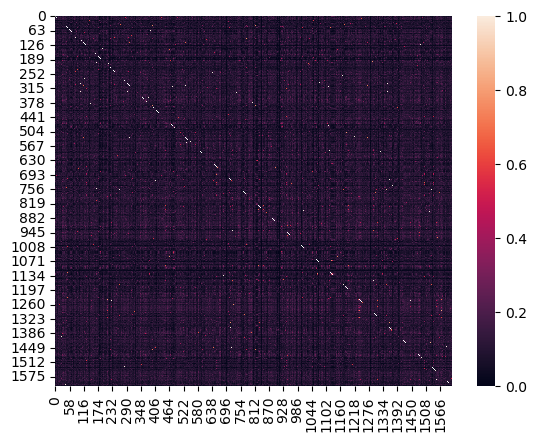

In [86]:
# Convert similarity_scores_arr to a square matrix with NaNs on the diagonal
similarities_arr = similarity_scores_arr.reshape(len(fp_binary), len(fp_binary))
np.fill_diagonal(similarities_arr, np.nan)

# Create a heatmap plot of the similarity matrix
sns.heatmap(similarities_arr)

* In the visualization of the similarity matrix, the dark purple with speckles of different hues suggests that there are multiple clusters or groups of molecules in the dataset that have different similarity profiles. 
<br>
* This could indicate that there is some level of structural diversity in the dataset and that the molecules may have distinct chemical features or properties. This makes sense considering the make-up of the dataset


##### t-SNE

* When interpreting t-SNE plots, it's important to keep in mind that the position of the points on the plot is arbitrary, and has no inherent meaning in and of itself. Instead, the relative positions of the points on the plot are what's important, as they reflect the patterns and relationships in the higher-dimensional data.

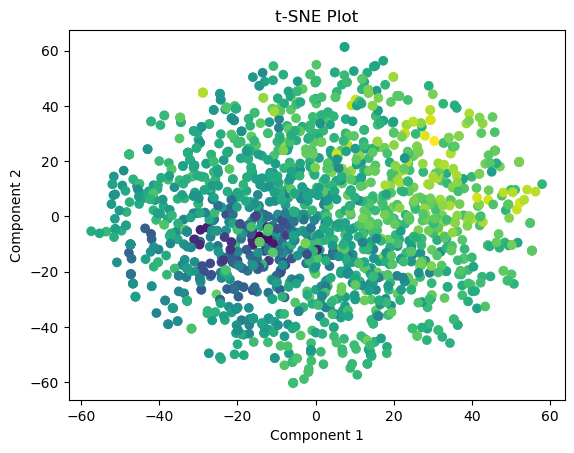

In [87]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Instantiate the t-SNE model with two components
X_subset = merged_df.drop(['zinc_id', 'smiles', 'Molecule Name', 'ROMol', 'Fingerprint'], axis=1)
tsne = TSNE(n_components=3)

# Fit and transform the dataset
X_tsne = tsne.fit_transform(X_subset)

# Create scatter plot of the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['similarity_mean'])
plt.title("t-SNE Plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

* The oval with no discernable color clusters suggests that there are no clearly defined groupings or clusters in the data based on Euclidean distance. The oval indicates that the overall distances between the points in the dataset are relatively similar, and that there are no large separations between the points.

d:\Envs\pycaret\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


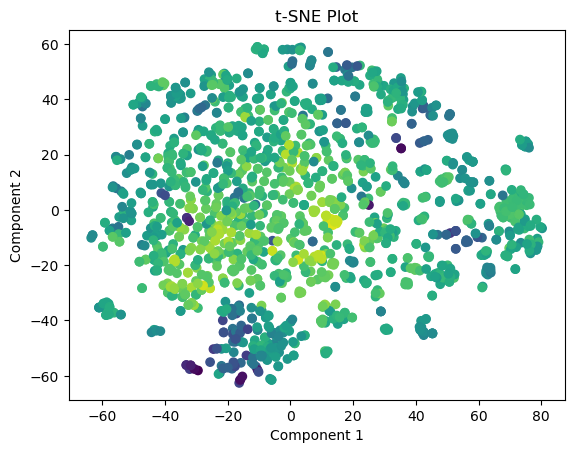

In [88]:
tsne = TSNE(n_components=2, metric='jaccard')

# Fit and transform the dataset
X_tsne = tsne.fit_transform(X_subset)

# Create scatter plot of the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['similarity_mean'])
plt.title("t-SNE Plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

* The less symmetrical and slightly better-defined clusters of color may suggest that there are more pronounced groupings or clusters in the data based on the Jaccard index.

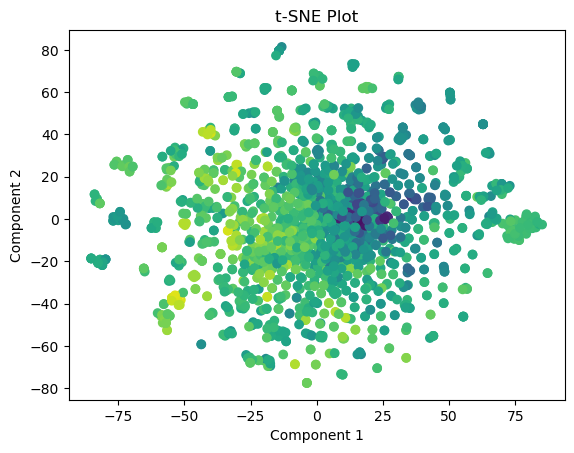

In [89]:
tsne = TSNE(n_components=2, metric='hamming')

# Fit and transform the dataset
X_tsne = tsne.fit_transform(X_subset)

# Create scatter plot of the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['similarity_mean'])
plt.title("t-SNE Plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

* The dense center, like an exploding star, could suggest that there is a common group of data points that are very similar to each other based on the Hamming distance. As you move outwards from the center, the data points become less similar to each other.
<br>

* The results of this visual analysis line up with the nature of the data. The fact that the Jaccard and Hamming show more clustering than the Euclidean indicates that the data may be more binary nature, which it is.

##### PCA

Variance explained by each principal component:  [0.012303   0.00991647]


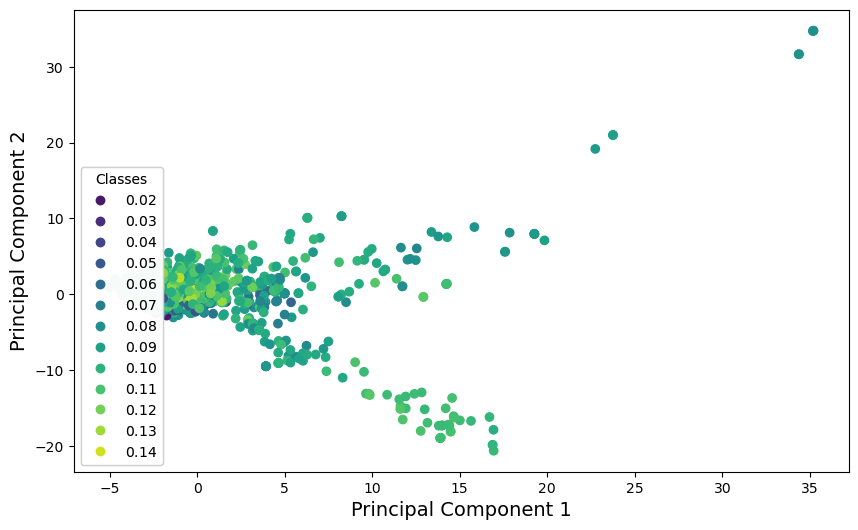

In [90]:
# Load data
data = pd.read_csv('D:/DataSets/FDA_1615.csv')

# Define the columns to exclude
exclude_cols = ['zinc_id', 'smiles', 'Molecule Name', 'ROMol', 'Fingerprint']

# Define the target variable
target_column = 'similarity_mean'

# Extract the features and target
X = data.drop(exclude_cols + [target_column], axis=1)
y = data[target_column]

# Standardize the features
X_transformed = StandardScaler().fit_transform(X)

# Initialize PCA with two principal components
pca = PCA(n_components=2)

# Fit and transform the data
X_pca = pca.fit_transform(X_transformed)

print('Variance explained by each principal component: ', pca.explained_variance_ratio_)

# Create a DataFrame with the transformed data and target
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df[target_column] = y

# Visualize the results with a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df[target_column])
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# Add a legend
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)

plt.show()

* The proportion of variance explained by each principal component is small; this is an expected result based on the data.
<br>
* There's no real separation of clusters in the data. Several data points are very distant, these could be outliers.